# Year of song predictor

In [1]:
import numpy as np
import pandas as pd

from bayes_opt import BayesianOptimization

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import KFold, train_test_split

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def plotLosses( losses ):
    """Plots training loss as a fucntion of epoch."""

    fig = plt.figure(1, figsize = (18,10))
    plt.plot( range(1, len(losses["loss"]) + 1), losses["loss"], "b-",
              linewidth = 3, label = "$\mathrm{training}$")
    plt.plot( range(1, len(losses["val_loss"]) + 1), losses["val_loss"], "g-",
              linewidth = 3, label = "$\mathrm{validation}$")
    plt.ylabel("$\mathrm{Loss}$")
    plt.xlabel("$\mathrm{Epoch}$")
    plt.yscale("log")
    plt.legend( loc = "best" )

    plt.show()

    return

def convert( params ):
    """A helper function used in formating a  print statement below."""
    
    return { "nl" : int(params["nl"]),
             "nh" : int(params["nh"]),
             "bs" : int(params["bs"]),
             "do" : params["do"] }

Using TensorFlow backend.


In [2]:
features = [ "val" + str(i) for i in range(1,91) ]
target = ["year"]
header = target + features

In [3]:
data = pd.read_csv( "YearPredictionMSD.txt", names = header )

In [4]:
train = data[:463715]
test  = data[463715:]

In [5]:
train.describe()

,year,val1,val2,val3,val4,val5,val6,val7,val8,val9,...,val81,val82,val83,val84,val85,val86,val87,val88,val89,val90
count,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,...,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000
mean,1998.386095,43.385488,1.261091,8.650195,1.130763,-6.512725,-9.565527,-2.384609,-1.793722,3.714584,...,15.743361,-73.067753,41.423976,37.780868,0.345259,17.599280,-26.364826,4.444985,19.739307,1.323326
std,10.939767,6.079139,51.613473,35.264750,16.334672,22.855820,12.836758,14.580245,7.961876,10.579241,...,32.086356,175.376872,121.794610,94.874474,16.153797,114.336522,174.187892,13.320996,184.843503,22.045404
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,...,-437.722030,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.378150,-318.223330
25%,1994.000000,39.957540,-26.153810,-11.441920,-8.515155,-20.636960,-18.468705,-10.776340,-6.461400,-2.303600,...,-1.798085,-139.062035,-20.918635,-4.711470,-6.758160,-31.563615,-101.396245,-2.572830,-59.598030,-8.813335
50%,2002.000000,44.262570,8.371550,10.470520,-0.691610,-5.992740,-11.208850,-2.047850,-1.735440,3.816840,...,9.161360,-52.878010,28.709870,33.494550,0.828350,15.554490,-21.123570,3.111120,7.586950,0.052840
75%,2006.000000,47.833650,36.143780,29.741165,8.756995,7.749590,-2.422590,6.515710,2.905130,9.950960,...,26.248290,13.620660,89.419995,77.674700,8.495715,67.743725,52.299850,9.948955,86.203115,9.670740
max,2011.000000,61.970140,384.065730,322.851430,289.527430,262.068870,119.815590,172.402680,105.210280,146.297950,...,840.973380,4469.454870,3210.701700,1672.647100,260.544900,3662.065650,2833.608950,463.419500,7393.398440,600.766240


## Extract the features and scale

In [6]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values

In [7]:
prepTarget   = Pipeline([ ("select", DataFrameSelector( target )),
                        ("scale",  MinMaxScaler()) ])
prepFeatures = Pipeline([ ("select", DataFrameSelector( features )),
                          ("scale",  MinMaxScaler()) ])

In [8]:
prepX = prepFeatures.fit_transform( train )
prepY = prepTarget.fit_transform( train )

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


## Define the model and a $L(n_l, n_h, d, N_b)$

where $n_l$ is the number of hidden layers (`nl`), $n_h$ is the size of each hidden layer (`nh`), $d$ is the dropout rate (`do`), and $N_b$ is the batch size (`bs`).

In [9]:
def genModel( nh = 100, nlayers = 1, dropout = 0.5 ):

    model = Sequential()

    model.add( Dense(nh, input_shape=(90,), activation = "elu" ) )

    for _ in range( nlayers - 1):
        model.add( BatchNormalization() )
        model.add( Dropout( dropout ) )
        model.add( Dense(nh, activation = "elu" ) )

    model.add( BatchNormalization() )
    model.add( Dropout( dropout ) )
    model.add( Dense(1, activation = "elu") )

    model.compile( optimizer = "adam", loss = "mse" )

    return model

In [10]:
def valLoss( nl, nh, do, bs ): #Maybe change this to train_test_split with test_size = 0.1 to be same as latter.

    kf = KFold( n_splits = 3, shuffle = True )
    vals = []

    for trIndex, teIndex in kf.split( prepX ):

        model = genModel( nlayers = int(nl), nh = int(nh), dropout = do )
        earlyStoper  = EarlyStopping( patience = 20, verbose = 0 )

        hist = model.fit( prepX[trIndex], prepY[trIndex],
                          validation_data = (prepX[teIndex], prepY[teIndex]),
                          verbose = 0,
                          epochs = 5000,
                          batch_size = int(bs),
                          callbacks = [earlyStoper] )

        vals.append( -np.min( hist.history["val_loss"] ) )

    return np.mean( vals )

## Find best (good) hyperparameter values via Bayesian optimization of $L$

In [11]:
loadData = True

params = { "nl" : [1, 10.9999],    "nh" : [16, 2048.9999],
           "do" : [0.0, 1.0], "bs" : [32, 2048.9999] }

opt = BayesianOptimization( valLoss, params )

if ( loadData ):
    prev = pd.read_csv( "points.csv" )
    opt.initialize_df( prev )

opt.maximize( init_points = 2, n_iter = 5, 
              acq = "ucb", kappa = 2.576 ) #ucb, ei, poi

opt.points_to_csv( "points.csv" )

Initialization
-----------------------------------------------------------------------------
 Step |   Time |      Value |        bs |        do |        nh |        nl | 
    1 | 04m42s |   -0.01012 | 1478.4076 |    0.3859 |  534.4493 |    3.8096 | 
    2 | 153m16s |   -0.00946 |  212.3517 |    0.5221 | 1947.4934 |    9.2549 | 
    3 | 00m00s |   -0.01362 |  510.6979 |    0.9439 |  956.8616 |    9.2141 | 
    4 | 00m00s |   -0.01114 |  301.3994 |    0.0867 | 1386.0430 |   10.7884 | 
    5 | 00m00s |   -0.01081 |  427.9305 |    0.2439 | 1420.4276 |    4.6085 | 
    6 | 00m00s |   -0.01191 | 1923.9815 |    0.7209 | 1183.3058 |    7.8390 | 
    7 | 00m00s |   -0.01512 | 1831.5700 |    0.9431 | 1892.6051 |    5.0795 | 
    8 | 00m00s |   -0.01020 |  886.0229 |    0.4019 |  206.9575 |    5.2304 | 
    9 | 00m00s |   -0.01511 | 1247.5726 |    0.9813 |  176.4166 |    7.6927 | 
   10 | 00m00s |   -0.01061 |  370.6026 |    0.5146 |   43.5769 |    2.1297 | 
   11 | 00m00s |   -0.01068 |  256.56

/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00019715]), 'funcalls': 55, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00730039]), 'funcalls': 52, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Bayesian Optimization
-----------------------------------------------------------------------------
 Step |   Time |      Value |        bs |        do |        nh |        nl | 
  116 | 168m18s |   -0.01511 |   41.6252 |    0.9443 |  540.9033 |   10.8649 | 
  117 | 81m23s |   -0.01043 |  133.6115 |    0.2602 |  715.8433 |    1.0032 | 
  118 | 39m25s |   -0.01069 |  289.7151 |    0.2229 |  963.6562 |   10.7829 | 


/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00605251]), 'funcalls': 56, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


  119 | 11m39s |   -0.01070 | 1246.0335 |    0.0263 |  967.5438 |    1.4662 | 
  120 | 20m41s |   -0.01056 |  762.0836 |    0.2761 |  629.3280 |    1.3423 | 


In [12]:
bestParams = opt.res["max"]["max_params"]

print( "Lowest validation loss: {}".format( -opt.res["max"]["max_val"] ) )
print( "Best parameters found: nl = {nl}, nh = {nh}, dropout = {do:1.2f}, batchSize = {bs}".format(**convert(bestParams)) )

Lowest validation loss: 0.00941884214544744
Best parameters found: nl = 3, nh = 985, dropout = 0.32, batchSize = 85


## Training/validation split

The validation set is chosen to have approximately the same size as the test set.

In [13]:
xTrain, xVal, yTrain, yVal = train_test_split( prepX, prepY, test_size = 0.1 )

## Train the model

In [14]:
model = genModel( nlayers = int(bestParams["nl"]),
                  nh = int(bestParams["nh"]),
                  dropout = bestParams["do"] )
batchSize = int(bestParams["bs"])

model.summary()

earlyStoper  = EarlyStopping( patience = 20, verbose = 0 )
checkPointer = ModelCheckpoint( filepath = "best.hdf5", save_best_only = True, verbose = 0 )

hist = model.fit( xTrain, yTrain,
                  validation_data = (xVal, yVal),
                  epochs = 5000,
                  verbose = 0,
                  batch_size = batchSize,
                  callbacks = [earlyStoper, checkPointer] )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_127 (Dense)            (None, 985)               89635     
_________________________________________________________________
batch_normalization_106 (Bat (None, 985)               3940      
_________________________________________________________________
dropout_106 (Dropout)        (None, 985)               0         
_________________________________________________________________
dense_128 (Dense)            (None, 985)               971210    
_________________________________________________________________
batch_normalization_107 (Bat (None, 985)               3940      
_________________________________________________________________
dropout_107 (Dropout)        (None, 985)               0         
_________________________________________________________________
dense_129 (Dense)            (None, 985)               971210    
__________

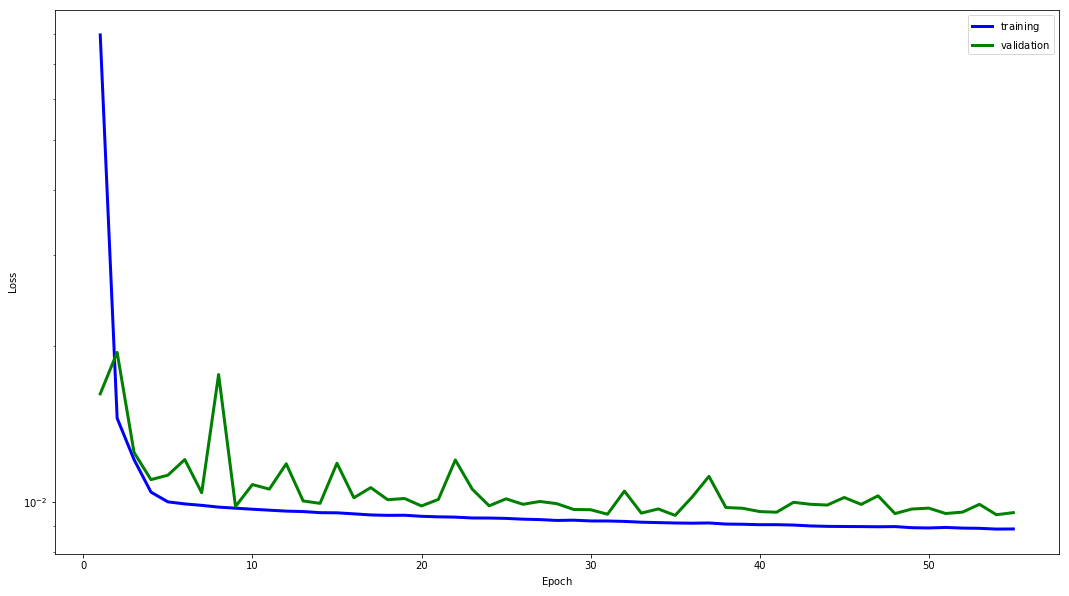

In [15]:
plotLosses( hist.history )

## Evaluate the model on the test set

In [16]:
testX = prepFeatures.transform( test )
testY = prepTarget.transform( test )

In [17]:
model.load_weights( "best.hdf5" )

ltr = model.evaluate( xTrain, yTrain )
lvl = model.evaluate( xVal, yVal )
lte = model.evaluate( testX, testY )

print( "\n" )
print( "Training:   {}".format(ltr) )
print( "Validation: {}".format(lvl) )
print( "Test:       {}".format(lte) )

51630/51630 [==============================] - 3s 51us/step


Training:   0.008745235336033752
Validation: 0.009426024753129114
Test:       0.009874997105954153


In [18]:
errTr = prepTarget.named_steps["scale"].data_range_ * np.sqrt( ltr )
errVl = prepTarget.named_steps["scale"].data_range_ * np.sqrt( lvl )
errTe = prepTarget.named_steps["scale"].data_range_ * np.sqrt( lte )

print( "\n" )
print( "Training error:   {:1.2f}".format(errTr[0]) )
print( "Validation error: {:1.2f}".format(errVl[0]) )
print( "Test error:       {:1.2f}".format(errTe[0]) )



Training error:   8.32
Validation error: 8.64
Test error:       8.84
